In [3]:
import numpy as np
import theano.tensor as tt
import pymc3 as pm
import arviz as az
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def model_factory(Y, n_subjects, n_times):
    
    t = np.tile(np.linspace(0.25, 12, n_times), n_subjects)
    
    subject_ids = np.concatenate([n_times*[i] for i in range(n_subjects)])
    
    with pm.Model() as pk_model:
        
        log_CL = pm.Normal('log_CL', tt.log(3.5), 0.075)
        z_CL = pm.Normal('z_CL', 0, 1, shape = len(np.unique(subject_ids)))
        s_CL = pm.Lognormal('s_CL', np.log(0.12), 0.05)
        
        log_ke = pm.Normal('log_ke', -1.5, 0.05)
        z_ke = pm.Normal('z_ke', 0, 1, shape = len(np.unique(subject_ids)))
        s_ke = pm.Lognormal('s_ke', tt.log(0.12), 0.05)
        
        alpha = pm.Beta('alpha', 30,100)
        log_ka = pm.Deterministic('log_ka', log_ke - tt.log(alpha))
        z_ka = pm.Normal('z_ka', 0, 1, shape = len(np.unique(subject_ids)))
        s_ka = pm.Lognormal('s_ka', tt.log(0.12), 0.05)
        
        CL = pm.Deterministic('Cl', tt.exp( log_CL + z_CL[np.unique(subject_ids)]*s_CL ))
        ke = pm.Deterministic('ke', tt.exp( log_ke + z_ke[np.unique(subject_ids)]*s_ke ))
        ka = pm.Deterministic('ka', tt.exp( log_ka + z_ka[np.unique(subject_ids)]*s_ka ))
        
        y_est = 5/CL[subject_ids]*(ke[subject_ids]*ka[subject_ids])/(ke[subject_ids]-ka[subject_ids])*(tt.exp(-ka[subject_ids]*t) - tt.exp(-ke[subject_ids]*t))
        
        y_conc = pm.Deterministic('y_est', y_est)
        sigma = pm.Lognormal('sigma', tt.log(0.12), 0.1)
        
        y = pm.Lognormal('yobs', tt.log(y_est), sigma, observed = Y)
        
    return pk_model,t, subject_ids


def weak_model_factory(Y, n_subjects, n_times):
    
    t = np.tile(np.linspace(0.25, 12, n_times), n_subjects)
    
    subject_ids = np.concatenate([n_times*[i] for i in range(n_subjects)])
    
    with pm.Model() as pk_model:
        
        log_CL = pm.Bound(pm.Normal, lower=0)('log_CL', tt.log(3.5), 1)
        z_CL = pm.Normal('z_CL', 0, 1, shape = len(np.unique(subject_ids)))
        s_CL = pm.HalfCauchy('s_CL',1)
        
        log_ke = pm.Normal('log_ke', -1.5, 1)
        z_ke = pm.Normal('z_ke', 0, 1, shape = len(np.unique(subject_ids)))
        s_ke = pm.HalfCauchy('s_ke', 1)
        
        alpha = pm.Beta('alpha', 1,1)
        log_ka = pm.Deterministic('log_ka', log_ke - tt.log(alpha))
        z_ka = pm.Normal('z_ka', 0, 1, shape = len(np.unique(subject_ids)))
        s_ka = pm.HalfCauchy('s_ka', 1)
        
        CL = pm.Deterministic('Cl', tt.exp( log_CL + z_CL[np.unique(subject_ids)]*s_CL ))
        ke = pm.Deterministic('ke', tt.exp( log_ke + z_ke[np.unique(subject_ids)]*s_ke ))
        ka = pm.Deterministic('ka', tt.exp( log_ka + z_ka[np.unique(subject_ids)]*s_ka ))
        
        y_est = 5/CL[subject_ids]*(ke[subject_ids]*ka[subject_ids])/(ke[subject_ids]-ka[subject_ids])*(tt.exp(-ka[subject_ids]*t) - tt.exp(-ke[subject_ids]*t))
        
        y_conc = pm.Deterministic('y_est', y_est)
        sigma = pm.HalfCauchy('sigma',1)
        
        y = pm.Lognormal('yobs', tt.log(y_est), sigma, observed = Y)
        
    return pk_model,t, subject_ids

    
    

In [5]:
n_subjects = 250
n_times = 5

pre_model,t,ids = model_factory(np.zeros(n_subjects*n_times), n_subjects, n_times)

with pre_model:
    bootstrap_prior = pm.sample_prior_predictive(samples=1, random_seed=0)

yobs=bootstrap_prior['yobs']
y=bootstrap_prior['y_est']

In [17]:
df = pd.DataFrame({'t':t, 'ids': ids, 'y':y , 'C': yobs})

if n_subjects<50:
    g = sns.FacetGrid(data = df, col='ids', col_wrap=6)

    g.map(plt.plot,'t','y')
    g.map(plt.plot, 't', 'C', color = 'red')
else:
    pass

In [18]:
model, t, ids = model_factory(yobs, n_subjects, n_times)
with model:
    prior = pm.sample_prior_predictive(samples=1, random_seed = 0)
    trace = pm.sample(draws=1000, tune = 1000, chains=8, random_seed = 0)
    posterior = pm.sample_posterior_predictive(trace, random_seed = 0)
    
model_data = az.from_pymc3(trace = trace, prior = prior, posterior_predictive=posterior)

weak_model, t, ids = weak_model_factory(yobs, n_subjects, n_times)
with weak_model:
    prior = pm.sample_prior_predictive(samples=1, random_seed = 0)
    trace = pm.sample(draws=1000, tune = 1000, chains=8, random_seed = 0)
    posterior = pm.sample_posterior_predictive(trace, random_seed = 0)
    
weak_data = az.from_pymc3(trace = trace, prior = prior, posterior_predictive=posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 2 jobs)
NUTS: [sigma, s_ka, z_ka, alpha, s_ke, z_ke, log_ke, s_CL, z_CL, log_CL]
Sampling 8 chains, 0 divergences:  51%|█████     | 8126/16000 [01:30<01:27, 89.75draws/s] 
The number of effective samples is smaller than 25% for some parameters.
100%|██████████| 4000/4000 [00:07<00:00, 536.89it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 2 jobs)
NUTS: [sigma, s_ka, z_ka, alpha, s_ke, z_ke, log_ke, s_CL, z_CL, log_CL]
100%|██████████| 8000/8000 [00:35<00:00, 223.46it/s]


In [8]:
def summarize_posterior(data, model_name):


    ppc = (
        data.
        posterior_predictive.
        yobs.
        to_dataframe().
        groupby(['yobs_dim_0']).
        agg([('ppc_mean',np.mean), 
            ('low_ppc', lambda x: np.quantile(x,0.025)),
            ('high_ppc', lambda x: np.quantile(x,0.975)) ])
    )

    pred = (
        data.
        posterior.
        y_est.
        to_dataframe().
        groupby(['y_est_dim_0']).
        agg([('pred',np.mean), 
            ('low', lambda x: np.quantile(x,0.025)),
            ('high', lambda x: np.quantile(x,0.975)) ])
    )



    ppc.columns = ppc.columns.droplevel()
    
    ppc.index.name = None

    pred.columns = pred.columns.droplevel()
    pred.index.name = None

    frame = ppc.join(pred)
    frame.columns = [model_name+'_'+j for j in frame.columns ]
    
    return frame


weak = summarize_posterior(weak_data,'weak')
strong = summarize_posterior(model_data,'strong')


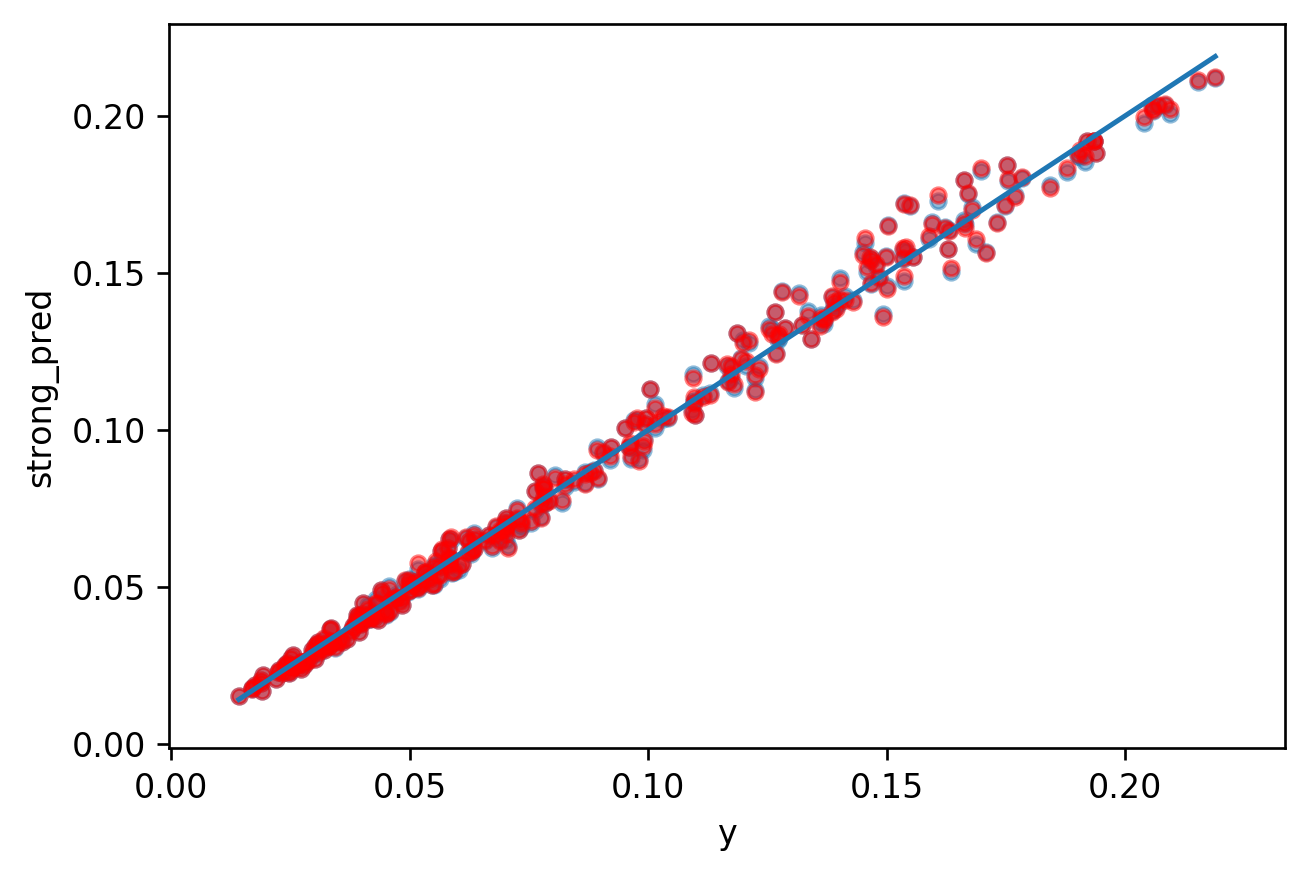

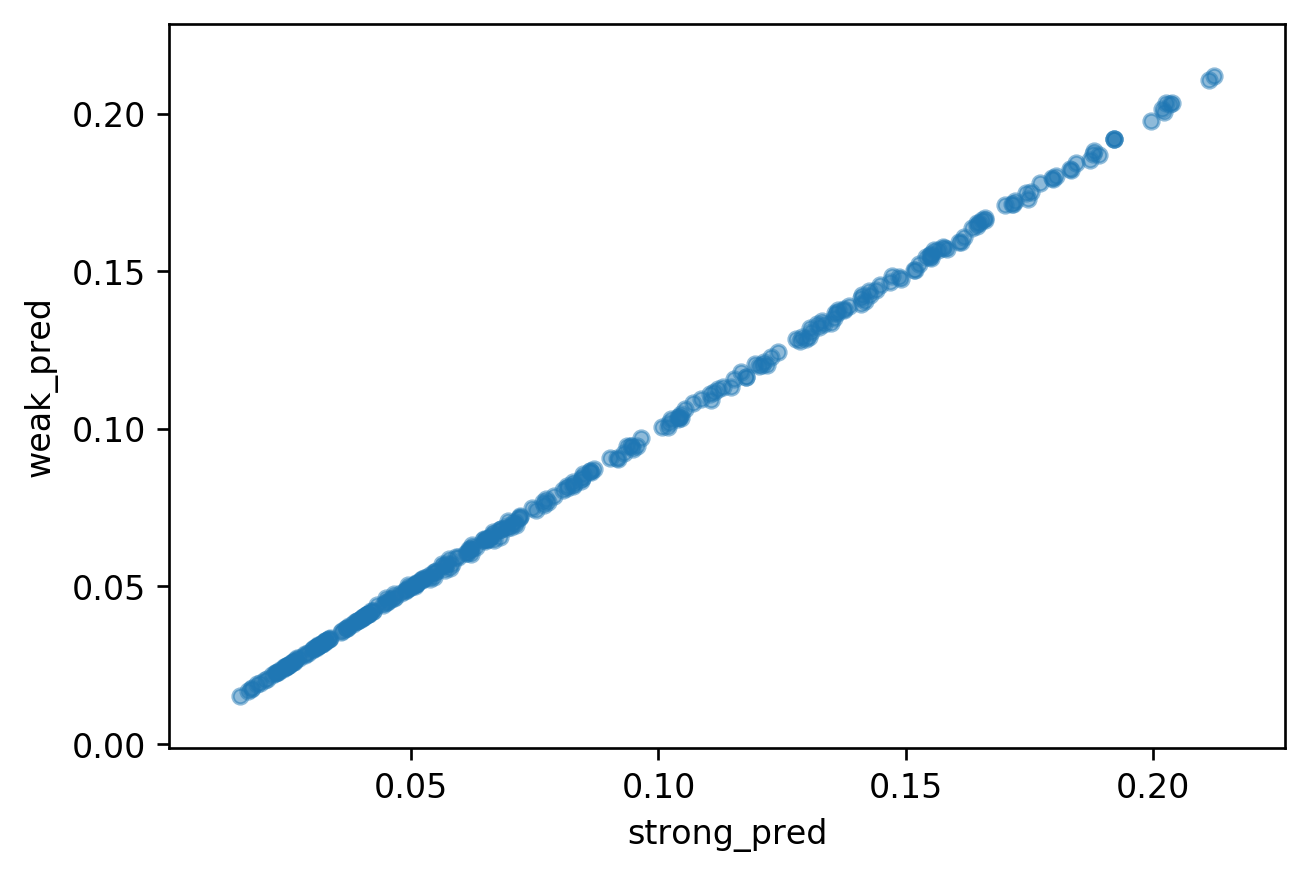

In [9]:
dfppc = df.join(weak).join(strong)

fig, ax = plt.subplots(dpi=120)
dfppc.plot.scatter(x='y', y='weak_pred', alpha = 0.5, ax = ax)
dfppc.plot.scatter(x='y', y='strong_pred', color = 'red', ax = ax, alpha = 0.5)
ax.plot(np.linspace(dfppc.y.min(), dfppc.y.max()),np.linspace(dfppc.y.min(), dfppc.y.max()))


fig, ax = plt.subplots(dpi=120)
dfppc.plot.scatter(x='strong_pred', y='weak_pred', alpha = 0.5, ax = ax)


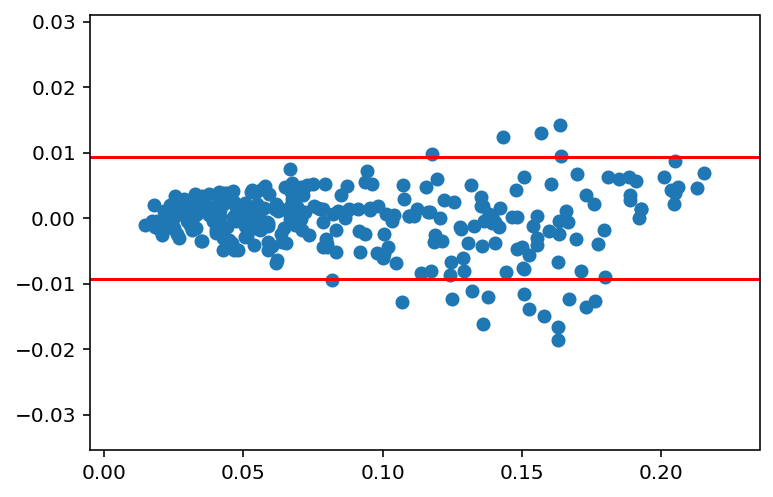

In [10]:
sig = np.std(dfppc.y-dfppc.weak_pred)
plt.scatter(dfppc.y/2 + dfppc.weak_pred/2, dfppc.y-dfppc.weak_pred)

plt.axhline(2*sig, color = 'red')
plt.axhline(-2*sig, color = 'red')

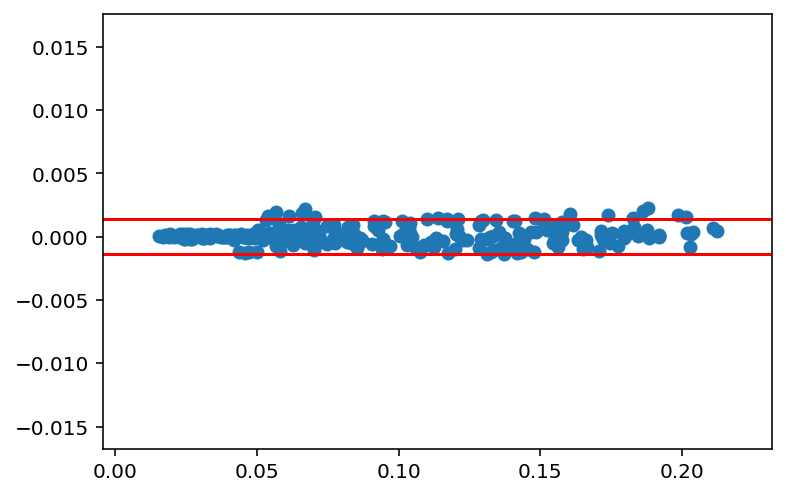

In [11]:
sig = np.std(dfppc.strong_pred-dfppc.weak_pred)
plt.scatter(dfppc.strong_pred/2 + dfppc.weak_pred/2, dfppc.strong_pred-dfppc.weak_pred)

plt.axhline(2*sig, color = 'red')
plt.axhline(-2*sig, color = 'red')

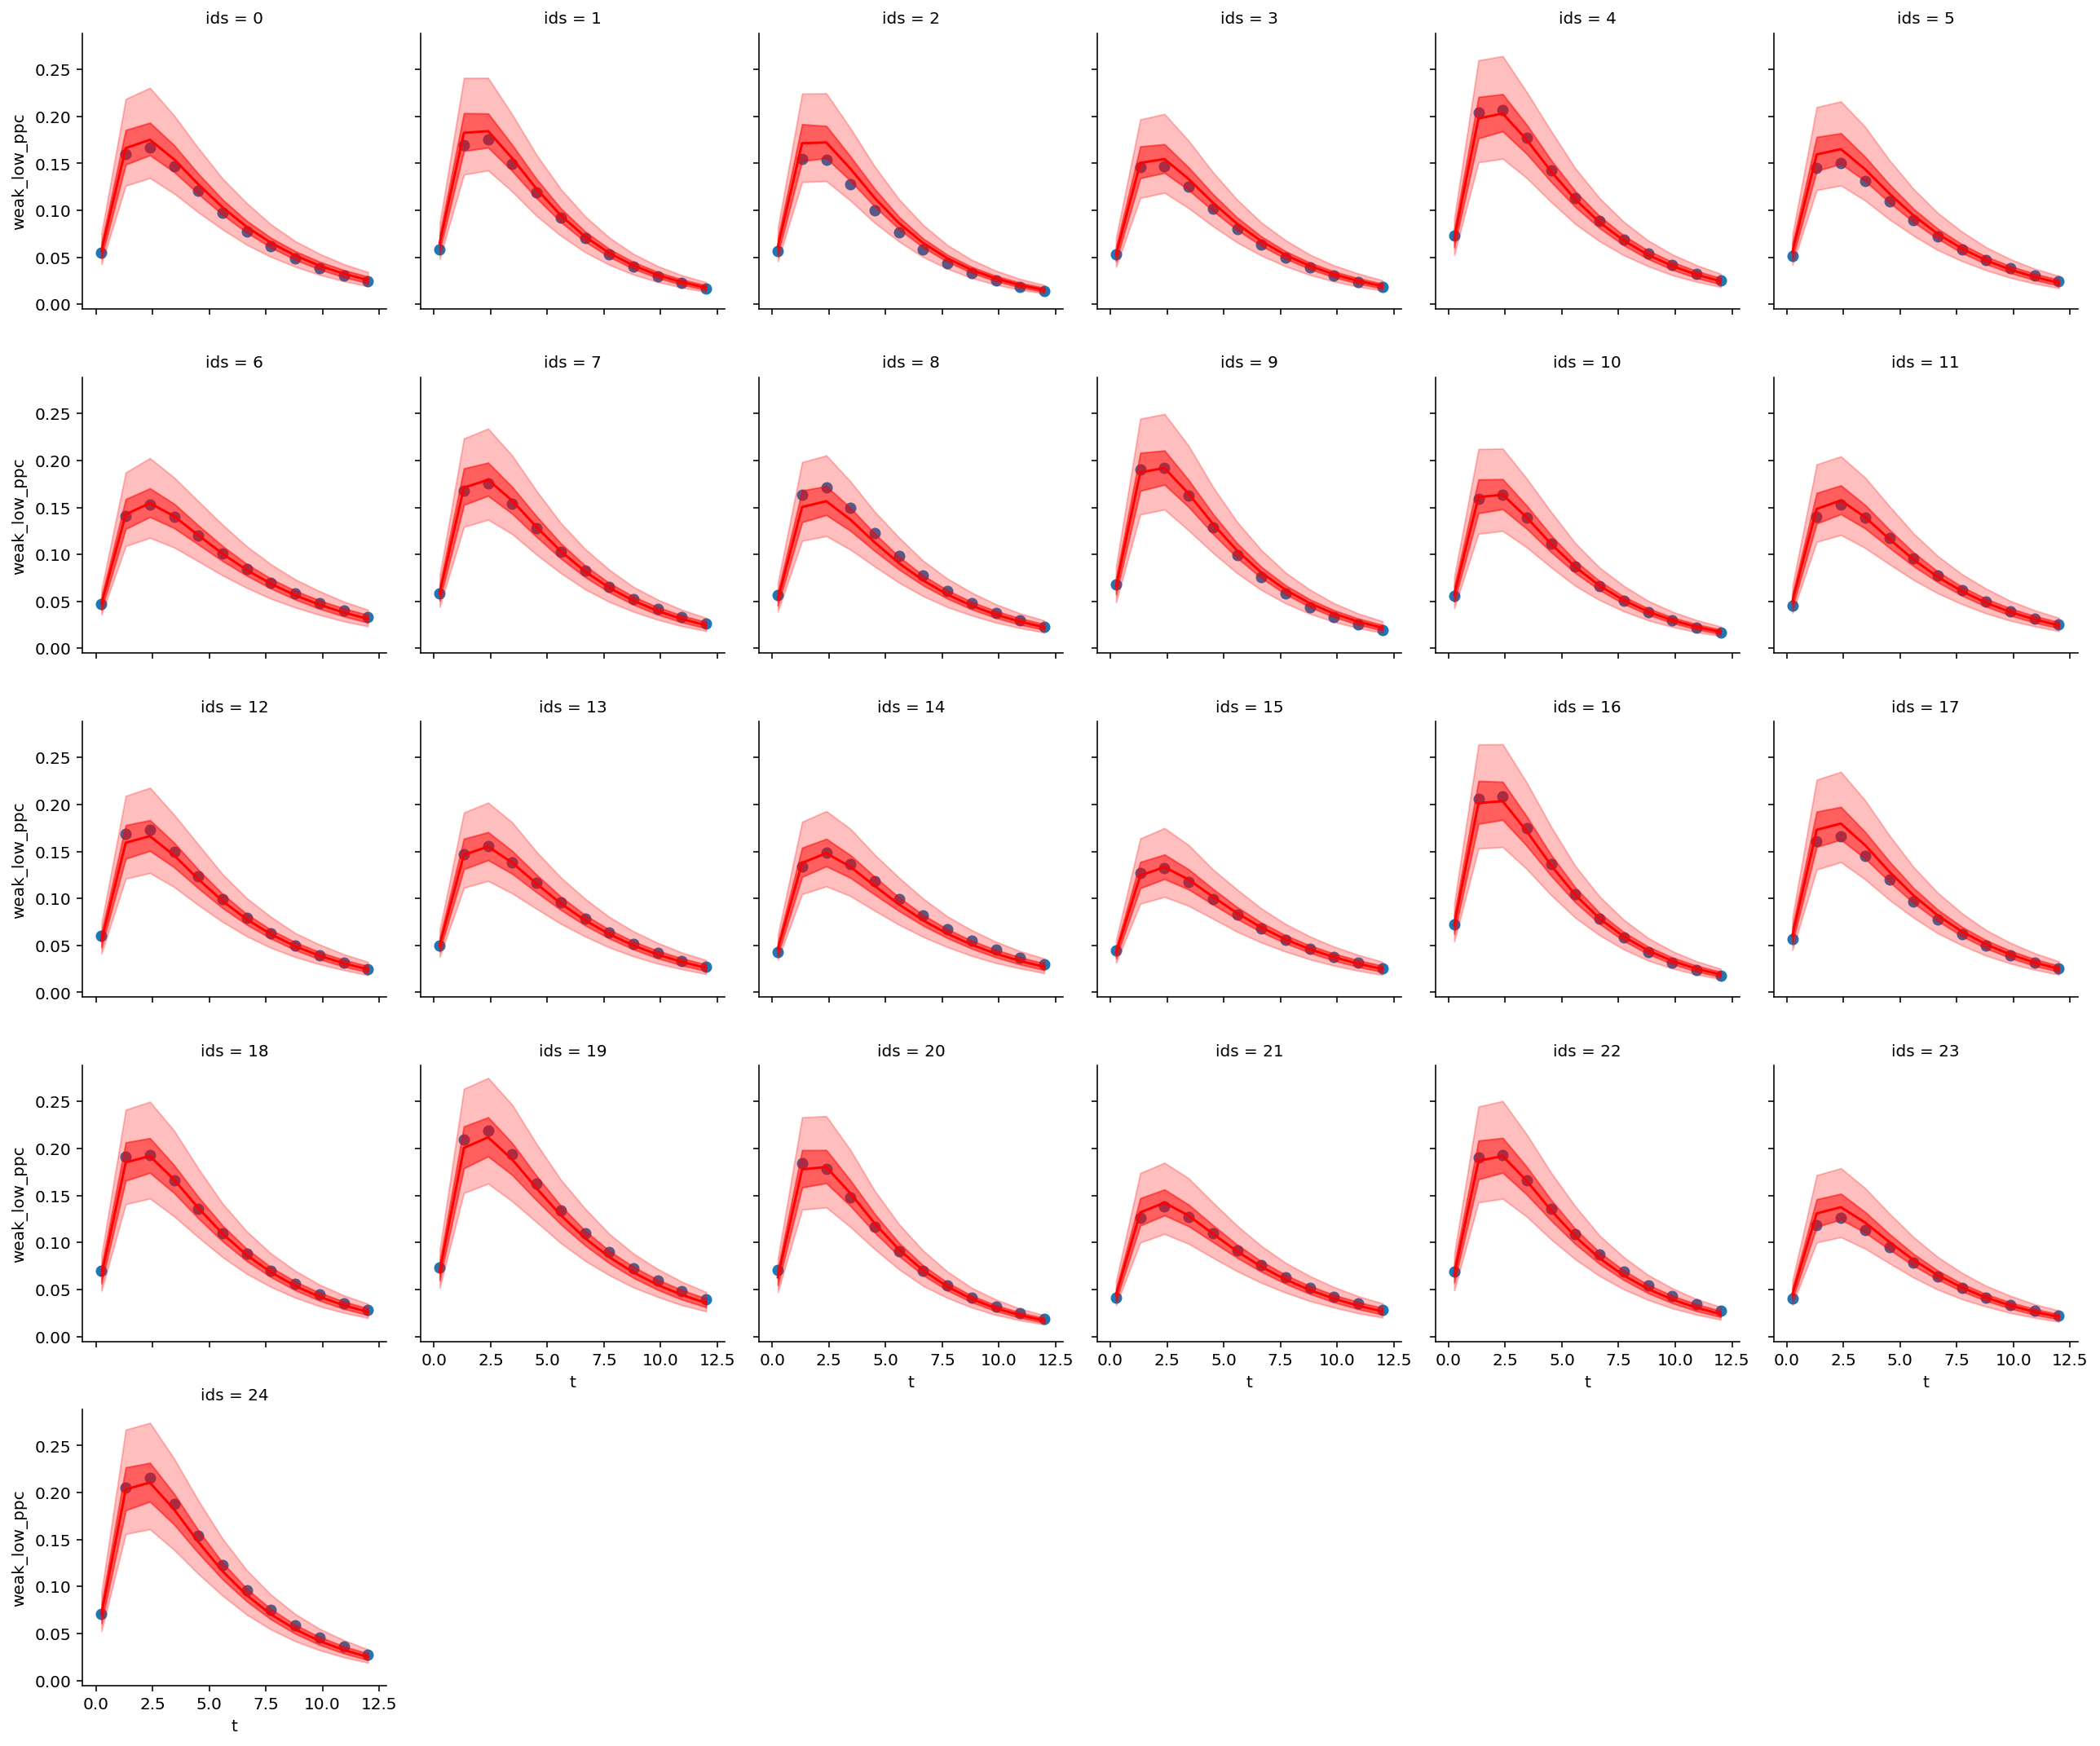

In [15]:

if n_subjects<50:
    g = sns.FacetGrid(data = dfppc, col='ids', col_wrap=6)
    g.map(plt.scatter, 't', 'y',)
    g.map(plt.plot, 't','weak_pred', color = 'red')
    g.map(plt.fill_between, 't','weak_low','weak_high', color ='red', alpha = 0.5)
    g.map(plt.fill_between, 't','weak_low_ppc','weak_high_ppc', color ='red', alpha = 0.25)


In [12]:
weak_data

NameError: name 'weak_data' is not defined